In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import heapq

In [3]:
INF = 1e1 # dont use np.inf to avoid inf * 0
EPS = 1e-1
KNOWN = 0
BAND = 1
INSIDE = 2

In [4]:


def create_mask(filename,threshold = 20,kernel_dim = (5,5)):
    # Reading the damaged image
    # print(threshold)
    damaged_img = cv2.imread(filename=filename)

    # Convert the damaged image to grayscale
    gray_img = cv2.cvtColor(damaged_img, cv2.COLOR_BGR2GRAY)

    # Thresholding to create a binary mask
    _, mask = cv2.threshold(gray_img,threshold , 255, cv2.THRESH_BINARY_INV)

    # Apply morphological opening to remove noise
    kernel = np.ones(kernel_dim, np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)

    return mask




# def create_mask(filename, threshold=0, kernel_dim=(5, 5)):
#     # Reading the damaged image
#     damaged_img = cv2.imread(filename=filename)

#     # Convert the damaged image to grayscale
#     gray_img = cv2.cvtColor(damaged_img, cv2.COLOR_BGR2GRAY)

#     # Create a binary mask for regions that are completely black
#     mask = np.where(gray_img == 0, 255, 0).astype(np.uint8)

#     # Apply smoothing (blurring) to the mask
#     mask = cv2.GaussianBlur(mask, kernel_dim, 0)

#     # Thresholding to convert pixel values to either 0 or 255
#     _, mask = cv2.threshold(mask, threshold, 255, cv2.THRESH_BINARY)

#     # Apply morphological opening to remove noise
#     kernel = np.ones(kernel_dim, np.uint8)
#     mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)

#     return mask



In [5]:
def visualize_image(image):
    # Convert BGR image to RGB (Matplotlib expects RGB)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Display the image
    plt.imshow(image_rgb)
    plt.axis('off')  # Turn off axis
    plt.show()


In [6]:
def get_image_and_mask(image_path,threshold = 20,kernel_dim=(5,5)):
  # Read the image
  image = cv2.imread(image_path)

  mask = create_mask(image_path,threshold,kernel_dim)

  visualize_image(image)
  visualize_image(mask)
  return image,mask


# get_image_and_mask("/content/drive/My Drive/BTP2_/dataset_black_fault/Copy of Image_293_defected.jpg")

In [7]:
faulty_images_path = "/content/drive/My Drive/BTP2_/dataset_black_fault"

for image_name in os.listdir(faulty_images_path):
    image_path = os.path.join(faulty_images_path, image_name)
    print(image_path)




/content/drive/My Drive/BTP2_/dataset_black_fault/Copy of Image_303_defected.jpg
/content/drive/My Drive/BTP2_/dataset_black_fault/Copy of Image_302_defected.jpg
/content/drive/My Drive/BTP2_/dataset_black_fault/Copy of Image_287_defected.jpg
/content/drive/My Drive/BTP2_/dataset_black_fault/Copy of Image_293_defected.jpg
/content/drive/My Drive/BTP2_/dataset_black_fault/Copy of Image_294_defected.jpg
/content/drive/My Drive/BTP2_/dataset_black_fault/Copy of Image_274_defected.jpg
/content/drive/My Drive/BTP2_/dataset_black_fault/Copy of Image_243_defected.jpg
/content/drive/My Drive/BTP2_/dataset_black_fault/Copy of Image_301_defected.jpg
/content/drive/My Drive/BTP2_/dataset_black_fault/Copy of Image_295_defected.jpg
/content/drive/My Drive/BTP2_/dataset_black_fault/Copy of Image_251_defected.jpg
/content/drive/My Drive/BTP2_/dataset_black_fault/Copy of Image_260_defected.jpg
/content/drive/My Drive/BTP2_/dataset_black_fault/Copy of Image_239_defected.jpg
/content/drive/My Drive/BTP2

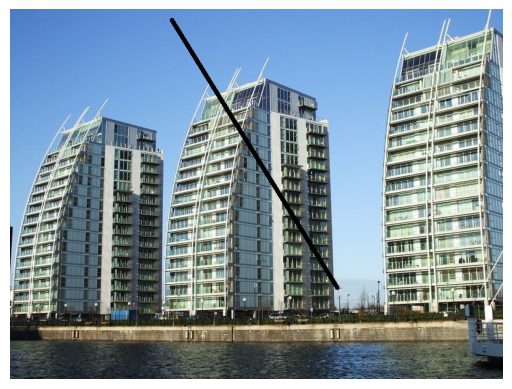

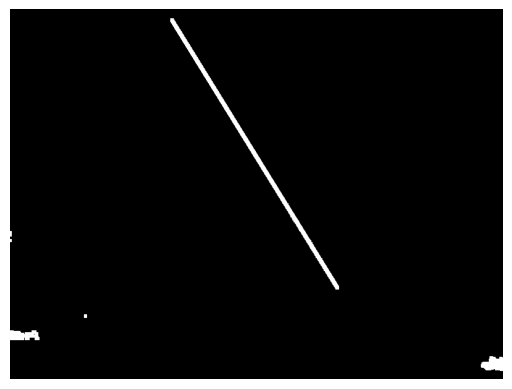

In [8]:
image_path = "/content/drive/My Drive/BTP2_/dataset_black_fault/Copy of Image_274_defected.jpg"

image, mask = get_image_and_mask(image_path)

In [9]:


def plot_points(coordinates):
    """
    Plot a list of coordinates on a graph.

    Parameters:
        coordinates (list): List of (x, y) coordinates.
    """
    x_values = [coord[0] for coord in coordinates]
    y_values = [coord[1] for coord in coordinates]

    plt.figure(figsize=(8, 6))
    plt.scatter(x_values, y_values, color='blue', label='Points')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Plot of Points')
    plt.grid(True)
    plt.legend()
    plt.show()

# # Example usage
# coordinates = [(1, 2), (3, 4), (5, 6), (7, 8)]
# plot_points(coordinates)


In [10]:
def extract_points_from_narrow_band(narrow_band):
    """
    Extracts points from the narrow_band list.

    Parameters:
        narrow_band (list): List of tuples containing (T_value, (x, y)) coordinates.

    Returns:
        points (list): List of (x, y) coordinates extracted from the narrow_band.
    """
    points = [coord for (_, coord) in narrow_band]
    return points




In [11]:
# returns gradient for one pixel, computed on 2 pixel range if possible
def _pixel_gradient(y, x, height, width, vals, flags):
    val = vals[y, x]

    # compute grad_y
    prev_y = y - 1
    next_y = y + 1
    if prev_y < 0 or next_y >= height:
        grad_y = INF
    else:
        flag_prev_y = flags[prev_y, x]
        flag_next_y = flags[next_y, x]

        if flag_prev_y != INSIDE and flag_next_y != INSIDE:
            grad_y = (vals[next_y, x] - vals[prev_y, x]) / 2.0
        elif flag_prev_y != INSIDE:
            grad_y = val - vals[prev_y, x]
        elif flag_next_y != INSIDE:
            grad_y = vals[next_y, x] - val
        else:
            grad_y = 0.0

    # compute grad_x
    prev_x = x - 1
    next_x = x + 1
    if prev_x < 0 or next_x >= width:
        grad_x = INF
    else:
        flag_prev_x = flags[y, prev_x]
        flag_next_x = flags[y, next_x]

        if flag_prev_x != INSIDE and flag_next_x != INSIDE:
            grad_x = (vals[y, next_x] - vals[y, prev_x]) / 2.0
        elif flag_prev_x != INSIDE:
            grad_x = val - vals[y, prev_x]
        elif flag_next_x != INSIDE:
            grad_x = vals[y, next_x] - val
        else:
            grad_x = 0.0

    return grad_y, grad_x


def inpaint_pixel(img, dists, flags, y, x,radius,height,width):
    dist = dists[y, x]
    # normal to pixel, ie direction of propagation of the FFM
    dist_grad_y, dist_grad_x = _pixel_gradient(y, x, height, width, dists, flags)
    pixel_sum = np.zeros((3), dtype=float)
    weight_sum = 0.0

    # iterate on each pixel in neighborhood (nb stands for neighbor)
    for nb_y in range(y - radius, y + radius + 1):
        #  pixel out of frame
        if nb_y < 0 or nb_y >= height:
            continue

        for nb_x in range(x - radius, x + radius + 1):
            # pixel out of frame
            if nb_x < 0 or nb_x >= width:
                continue

            # skip unknown pixels (including pixel being inpainted)
            if flags[nb_y, nb_x] == INSIDE:
                continue

            # vector from point to neighbor
            dir_y = y - nb_y
            dir_x = x - nb_x
            dir_length_square = dir_y ** 2 + dir_x ** 2
            dir_length = np.sqrt(dir_length_square)
            # pixel out of neighborhood
            if dir_length > radius:
                continue

            # compute weight
            # neighbor has same direction gradient => contributes more
            dir_factor = abs(dir_y * dist_grad_y + dir_x * dist_grad_x)
            if dir_factor == 0.0:
                dir_factor = EPS

            # neighbor has same contour distance => contributes more
            nb_dist = dists[nb_y, nb_x]
            level_factor = 1.0 / (1.0 + abs(nb_dist - dist))

            # neighbor is distant => contributes less
            dist_factor = 1.0 / (dir_length * dir_length_square)

            weight = abs(dir_factor * dist_factor * level_factor)

            pixel_sum[0] += weight * img[nb_y, nb_x, 0]
            pixel_sum[1] += weight * img[nb_y, nb_x, 1]
            pixel_sum[2] += weight * img[nb_y, nb_x, 2]

            weight_sum += weight

    return pixel_sum / weight_sum



In [12]:
def get_T_falgs_narrow_band(image,mask):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    height, width = image.shape[0:2]

    # Initialize T values
    T = np.zeros_like(gray, dtype=float)

    T[mask == 255] = INF  # Set large value inside the inpainting region

    # Initialize flag f
    f = np.where(mask == 255, INSIDE, KNOWN)

    # Initialize narrow band as a min heap
    narrow_band = []

    # Iterate over boundary pixels to initialize narrow band
    for i in range(1, gray.shape[0] - 1):
        for j in range(1, gray.shape[1] - 1):
            if f[i, j] == INSIDE:
                for k, l in [(i-1, j), (i, j-1), (i+1, j), (i, j+1),(i-1,j-1),(i-1,j+1),(i+1,j-1),(i+1,j+1)]:
                    if f[k, l] == KNOWN:
                        f[k,l] = BAND
                        T[i, j] = 0
                        heapq.heappush(narrow_band, (T[i, j], (i, j)))
                        break
    # print(len(narrow_band))
    # # Assuming narrow_band is the list of points obtained from the inpainting process
    # points = extract_points_from_narrow_band(narrow_band)
    # # Now you can use the plot_points function to plot these points
    # plot_points(points)
    return T,f,narrow_band



def inpaint_image(image, mask, radius=3):

    T,f, narrow_band = get_T_falgs_narrow_band(image,mask)
    height, width = image.shape[0:2]

    while narrow_band:

        # Extract pixel (i, j) from head of narrow band
        T_val, (i, j) = heapq.heappop(narrow_band)

        # Set flag f(i, j) to KNOWN
        f[i, j] = KNOWN

        # Iterate over neighboring pixels
        for k, l in [(i-1, j), (i, j-1), (i+1, j), (i, j+1)]:
            if (k < 1 or l < 1 or k >= mask.shape[0]-1 or l >= mask.shape[1]-1):
                continue
            # Check if neighboring pixel is not KNOWN
            if f[k, l] != KNOWN:
                # If neighboring pixel is INSIDE, set it to BAND and inpaint
                if f[k, l] == INSIDE:

                    # Compute T value for neighboring pixel
                    T[k,l] = min(solve(T, f, k-1, l, k, l-1),
                                 solve(T, f, k+1, l, k, l-1),
                                 solve(T, f, k-1, l, k, l+1),
                                 solve(T, f, k+1, l, k, l+1))

                    pixel_vals = inpaint_pixel(image,T,f, k,l,radius,height,width)

                    image[k,l,0] = pixel_vals[0]
                    image[k,l,1] = pixel_vals[1]
                    image[k,l,2] = pixel_vals[2]
                    # image[k,l,0] = 255
                    # image[k,l,1] = 255
                    # image[k,l,2] = 255

                    # Insert neighboring pixel into narrow band
                    heapq.heappush(narrow_band, (T[k,l], (k, l)))
                    f[k, l] = BAND


    return image





def solve(T, f, i1, j1, i2, j2):
    if i1 < 0 or i1 >= T.shape[0] or j1 < 0 or j1 >= T.shape[1]:
        return INF

    if i2 < 0 or i2 >= T.shape[0] or j2 < 0 or j2 >= T.shape[1]:
        return INF


    sol = INF
    flag1 = f[i1, j1]
    flag2 = f[i2, j2]

    # Both pixels are known
    if flag1 == KNOWN and flag2 == KNOWN:
        dist1 = T[i1, j1]
        dist2 = T[i2, j2]
        d = 2.0 - (dist1 - dist2) ** 2
        if d > 0.0:
            r = np.sqrt(d)
            s = (dist1 + dist2 - r) / 2.0
            if s >= dist1 and s >= dist2:
                sol = s
            else:
                s += r
                if s >= dist1 and s >= dist2:
                    sol = s
                else:
                    # Unsolvable
                    sol = INF

    # Only 1st pixel is known
    elif flag1 == KNOWN:
        sol = 1.0 + T[i1, j1]

    # Only 2nd pixel is known
    elif flag2 == KNOWN:
        sol = 1.0 + T[i2, j2]

    # No pixel is known
    else:
        sol = INF

    return sol






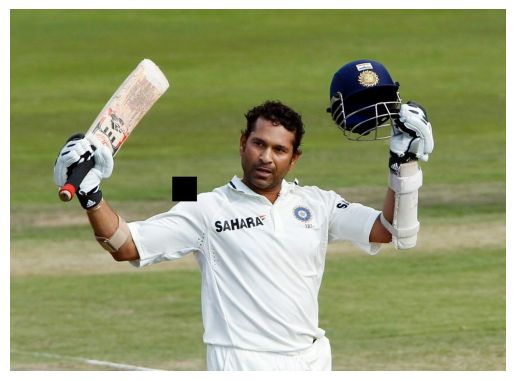

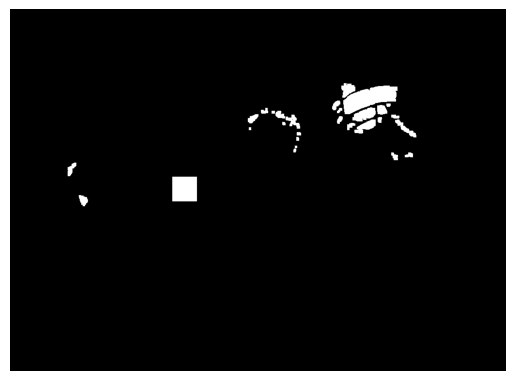

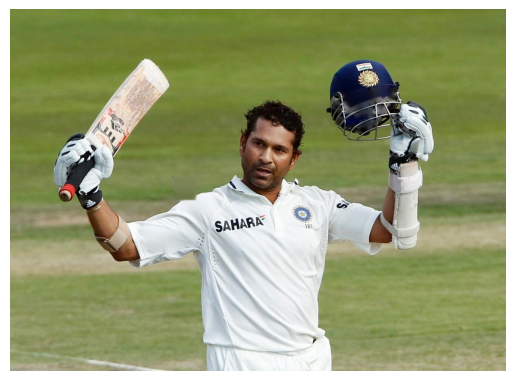

In [13]:
image_path = "/content/drive/My Drive/BTP2_/dataset_black_fault/Copy of Image_303_defected.jpg"

threshold = 10
image, mask = get_image_and_mask(image_path,threshold)


inpainted_image = inpaint_image(image, mask,7)

visualize_image(inpainted_image)

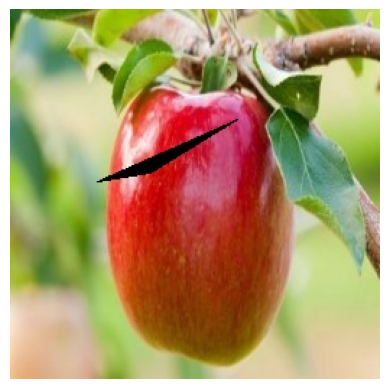

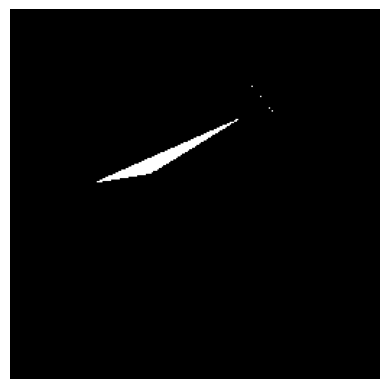

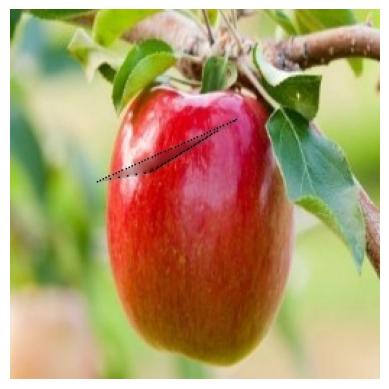

In [14]:
image_path = "/content/drive/My Drive/BTP2_/dataset_black_fault/Copy of Image_208_defected.jpg"

threshold = 20

kernel_dim = (1,1)
image, mask = get_image_and_mask(image_path,threshold,kernel_dim)


inpainted_image = inpaint_image(image, mask,7)

visualize_image(inpainted_image)

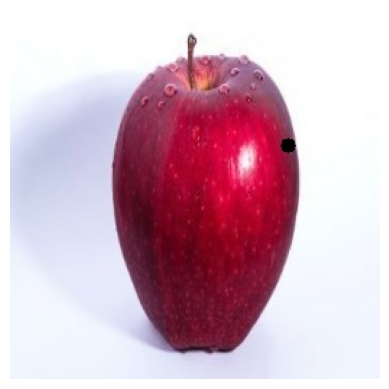

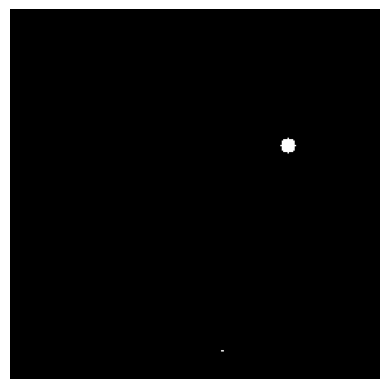

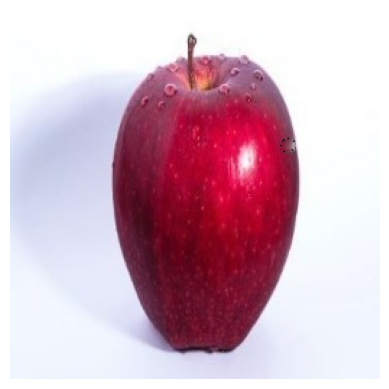

In [15]:
image_path = "/content/drive/My Drive/BTP2_/dataset_black_fault/Copy of Image_214_defected.jpg"

threshold = 20
kernel_dim = (1,1)
image, mask = get_image_and_mask(image_path,threshold,kernel_dim)


inpainted_image = inpaint_image(image, mask,7)

visualize_image(inpainted_image)

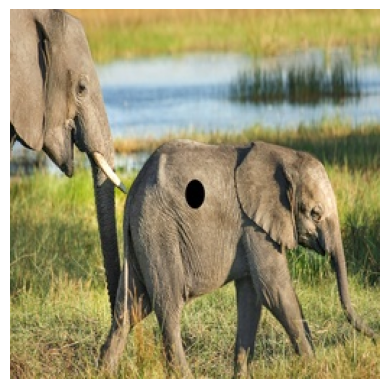

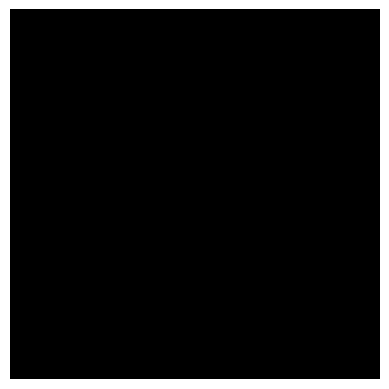

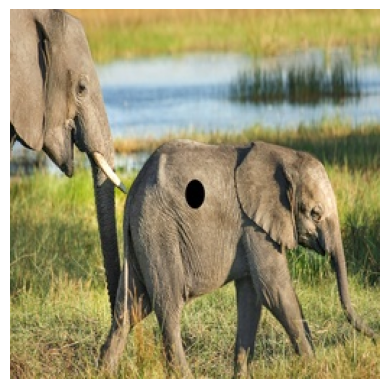

In [16]:
image_path = "/content/drive/My Drive/BTP2_/dataset_black_fault/Copy of Image_907.jpg"

threshold = 1
kernel_dim = (2,2)

image, mask = get_image_and_mask(image_path,threshold)


inpainted_image = inpaint_image(image, mask,7)

visualize_image(inpainted_image)